<a href="https://colab.research.google.com/github/sujin-create/hodlhodl/blob/Price-Prediction/Bitcoin%20price%20prediction%20using%20VIX%20and%20Google%20trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [ ]:
!pip install pyupbit    # 파이업비트 가상화폐 데이터 모듈
!pip install pymysql    # mysql에 데이터 삽입을 위한 모듈
!pip install schedule   # ec2에 스케쥴링 설정을 위한 모듈
!pip install yfinance   # VIX 지수를 가져오기 위한 모듈
!pip install pytrends   # google trend를 가져오기 위한 모듈

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 12.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 8.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account 

In [ ]:
import pyupbit
import pandas as pd
import time
import datetime 
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor
import tensorflow as tf
import warnings


# vix지수, 구글트렌트 지수 불러오기 위해 추가한 라이브러리
import pymysql 
import schedule
import yfinance as yf
from datetime import datetime
import pytrends
from pytrends.request import TrendReq

# Google trend

In [ ]:
# google trend
keyword = ["bitcoin"]   # Bitcoin 키워드의 데이터를 가져옴
startdate = "2017-09-25"
enddate = str(datetime.today()).split(" ")[0]
timerange = startdate + " " + enddate   # 시작날짜 ~ 오늘날짜까지의 데이터를 가져옴

result = pd.DataFrame()
pytrends = TrendReq()
pytrends.build_payload(kw_list=keyword, timeframe=timerange)
trends = pytrends.interest_over_time()

trends = trends[["bitcoin"]]
trends = trends.reset_index()
trends = trends.rename(columns={"date": "Date", "bitcoin": "trends"})
print(trends)

          Date  trends
0   2017-10-01      12
1   2017-10-08      18
2   2017-10-15      19
3   2017-10-22      20
4   2017-10-29      26
..         ...     ...
239 2022-05-01      19
240 2022-05-08      41
241 2022-05-15      27
242 2022-05-22      22
243 2022-05-29      21

[244 rows x 2 columns]


# VIX

In [ ]:
final = datetime.today()
vix = yf.download('^VIX', interval='1d', start="2017-09-25", end=final)['Close']
vix = pd.DataFrame(vix)
vix_close = vix.rename(columns={"Close": "vix_close"})
print(vix)

[*********************100%***********************]  1 of 1 completed
                Close
Date                 
2017-09-25  10.210000
2017-09-26  10.170000
2017-09-27   9.870000
2017-09-28   9.550000
2017-09-29   9.510000
...               ...
2022-05-25  28.370001
2022-05-26  27.500000
2022-05-27  25.719999
2022-05-31  26.190001
2022-06-01  25.690001

[1180 rows x 1 columns]


# Data Preprocessing

In [ ]:
# upbit
ticker = "KRW-BTC"
df = pyupbit.get_ohlcv(ticker, interval="day", count = 3650).reset_index() # count=200(default)
df_org = df.copy()

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)

Text(0.5, 1.0, 'ETH')

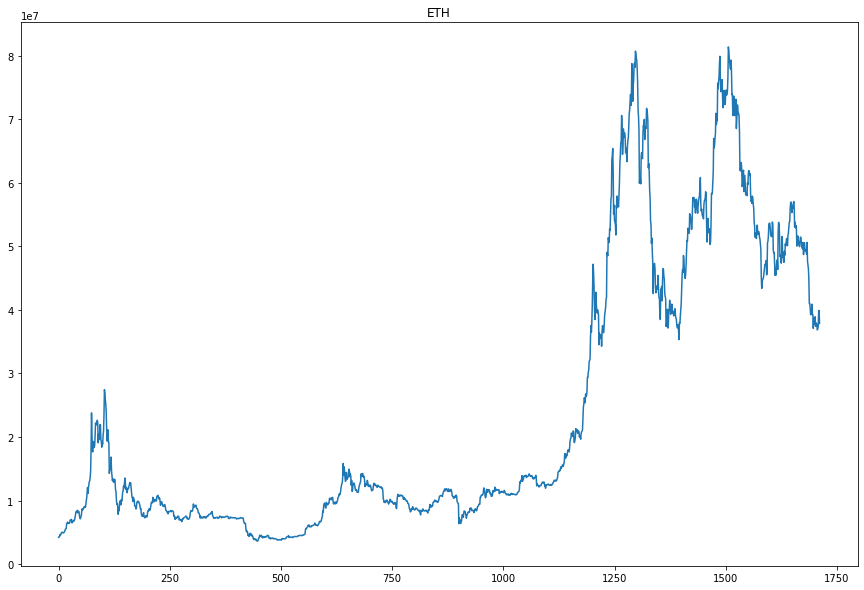

In [ ]:
plt.plot(df['open'])
plt.title('ETH')

In [ ]:
# datetime 형태의 Date 컬럼
df.reset_index(inplace=True)
df = df.rename(columns={"index": "Date"})
df["Date"] = pd.to_datetime(df["Date"].dt.date)

# vix 종가를 df에 결합 
df = pd.merge(df, vix_close, on="Date", how="left")

# 공휴일 vix 가격을 전날 가격으로 대치 
df = df.fillna(method = "ffill")

# trends 데이터를 df에 결합
df = pd.merge(df, trends, on="Date", how="outer")

# 주간 트렌드를 일별로 채우기
df = df.fillna(method="ffill")
df = df.fillna(method="bfill")
df2 = df

# smoothing by MA
df2["close_ma5"] = df2["close"].rolling(window=5).mean()
df2["close_ma10"] = df2["close"].rolling(window=10).mean()
df2["close_ma20"] = df2["close"].rolling(window=20).mean()
df2["close_ma60"] = df2["close"].rolling(window=60).mean()

df2["vix_close_ma5"] = df2["vix_close"].rolling(window=5).mean()
df2["vix_close_ma10"] = df2["vix_close"].rolling(window=10).mean()
df2["vix_close_ma20"] = df2["vix_close"].rolling(window=20).mean()
df2["vix_close_ma60"] = df2["vix_close"].rolling(window=60).mean()

df = df2[["close_ma5", "close_ma10", "close_ma20", "close_ma60", 
          "vix_close_ma5", "vix_close_ma10", "vix_close_ma20", "vix_close_ma60",
          "trends", "close"]]

# ma로 인해 생긴 결측 제거
df = df.dropna()
df_drop = df

warnings.filterwarnings('ignore')

# inverse transform
def restore(row):
    return row * (max(df_drop["close"]) - min(df_drop["close"])) + min(df_drop["close"])


scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의
scale_cols = ["close_ma5", "close_ma10", "close_ma20", "close_ma60", 
              "vix_close_ma5", "vix_close_ma10", "vix_close_ma20", "vix_close_ma60",
              "trends", "close"]
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])
df = pd.DataFrame(scaled, columns=scale_cols)
x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=0, shuffle=False)
df2 = df_org

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE=10
BATCH_SIZE=32

# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')


데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 10, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [ ]:
# GRU-Adaboost FIT
model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

# adaboost
GRU_Predictors = KerasRegressor(build_fn=lambda:model, epochs=50, batch_size=32)   # epoch수 변경
final_model = AdaBoostRegressor(GRU_Predictors, n_estimators=5, random_state=42)

final_model.fit(x_train,y_train)

print("예측을 시작합니다.")
preds = final_model.predict(x_test)
print("예측을 종료합니다.")

# print(preds)

Epoch 1/50
42/42 [==============================] - 7s 20ms/step - loss: 0.0305
Epoch 2/50
42/42 [==============================] - 1s 18ms/step - loss: 0.0066
Epoch 3/50
42/42 [==============================] - 1s 19ms/step - loss: 0.0034
Epoch 4/50
42/42 [==============================] - 1s 22ms/step - loss: 0.0030
Epoch 5/50
42/42 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 6/50
42/42 [==============================] - 1s 21ms/step - loss: 0.0024
Epoch 7/50
42/42 [==============================] - 1s 21ms/step - loss: 0.0032
Epoch 8/50
42/42 [==============================] - 1s 15ms/step - loss: 0.0028
Epoch 9/50
42/42 [==============================] - 1s 22ms/step - loss: 0.0028
Epoch 10/50
42/42 [==============================] - 1s 22ms/step - loss: 0.0024
Epoch 11/50
42/42 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 12/50
42/42 [==============================] - 1s 17ms/step - loss: 0.0024
Epoch 13/50
42/42 [==================

In [ ]:
df_actu = df_org[-len(preds):]

In [ ]:
df_actu.tail()

,index,open,high,low,close,volume,value
1707,2022-05-29 09:00:00+00:00,37033000.0,37620000.0,36825000.0,37380000.0,1712.650146,6.369122e+10
1708,2022-05-30 09:00:00+00:00,37415000.0,39989000.0,37230000.0,39550000.0,5467.460037,2.112747e+11
1709,2022-05-31 09:00:00+00:00,39527000.0,40600000.0,39300000.0,39923000.0,6442.979981,2.563085e+11
1710,2022-06-01 09:00:00+00:00,39927000.0,40150000.0,37500000.0,37880000.0,6304.814273,2.457440e+11
1711,2022-06-02 09:00:00+00:00,37880000.0,38000000.0,37670000.0,37936000.0,1000.900137,3.786106e+10


In [ ]:
df_actu["pred"] = restore(preds)
df_actu

,index,open,high,low,close,volume,value,pred
1381,2021-07-07 09:00:00+00:00,39814000.0,40727000.0,39637000.0,39743000.0,5761.286820,2.317461e+11,39045624.0
1382,2021-07-08 09:00:00+00:00,39743000.0,39953000.0,38200000.0,39082000.0,8178.526672,3.184049e+11,38929424.0
1383,2021-07-09 09:00:00+00:00,39069000.0,40070000.0,38123000.0,39820000.0,6163.102735,2.407772e+11,38698544.0
1384,2021-07-10 09:00:00+00:00,39801000.0,40302000.0,39124000.0,39626000.0,4161.719196,1.657401e+11,38795316.0
1385,2021-07-11 09:00:00+00:00,39633000.0,40580000.0,39250000.0,40194000.0,3892.503362,1.550557e+11,38894560.0
...,...,...,...,...,...,...,...,...
1707,2022-05-29 09:00:00+00:00,37033000.0,37620000.0,36825000.0,37380000.0,1712.650146,6.369122e+10,37601556.0
1708,2022-05-30 09:00:00+00:00,37415000.0,39989000.0,37230000.0,39550000.0,5467.460037,2.112747e+11,38046136.0
1709,2022-05-31 09:00:00+00:00,39527000.0,40600000.0,39300000.0,39923000.0,6442.979981,2.563085e+11,38670624.0
1710,2022-06-01 09:00:00+00:00,39927000.0,40150000.0,37500000.0,37880000.0,6304.814273,2.457440e+11,38940424.0


In [ ]:
df_actu = df_actu[["index","close", "pred"]]
df_actu

,index,close,pred
1381,2021-07-07 09:00:00+00:00,39743000.0,39045624.0
1382,2021-07-08 09:00:00+00:00,39082000.0,38929424.0
1383,2021-07-09 09:00:00+00:00,39820000.0,38698544.0
1384,2021-07-10 09:00:00+00:00,39626000.0,38795316.0
1385,2021-07-11 09:00:00+00:00,40194000.0,38894560.0
...,...,...,...
1707,2022-05-29 09:00:00+00:00,37380000.0,37601556.0
1708,2022-05-30 09:00:00+00:00,39550000.0,38046136.0
1709,2022-05-31 09:00:00+00:00,39923000.0,38670624.0
1710,2022-06-01 09:00:00+00:00,37880000.0,38940424.0


In [ ]:
prediction_data = df_actu

prediction_data.reset_index(inplace=True)
prediction_data = prediction_data.rename(columns={"index": "date"})

In [ ]:
prediction_data

,level_0,date,close,pred
0,1381,2021-07-07 09:00:00+00:00,39743000.0,39045624.0
1,1382,2021-07-08 09:00:00+00:00,39082000.0,38929424.0
2,1383,2021-07-09 09:00:00+00:00,39820000.0,38698544.0
3,1384,2021-07-10 09:00:00+00:00,39626000.0,38795316.0
4,1385,2021-07-11 09:00:00+00:00,40194000.0,38894560.0
...,...,...,...,...
326,1707,2022-05-29 09:00:00+00:00,37380000.0,37601556.0
327,1708,2022-05-30 09:00:00+00:00,39550000.0,38046136.0
328,1709,2022-05-31 09:00:00+00:00,39923000.0,38670624.0
329,1710,2022-06-01 09:00:00+00:00,37880000.0,38940424.0


In [ ]:
prediction_data['date'] = pd.to_datetime(prediction_data['date']).dt.date   # 날짜 뒤에 나오는 시간 제거

In [ ]:
prediction_data['date']

0      2021-07-07
1      2021-07-08
2      2021-07-09
3      2021-07-10
4      2021-07-11
          ...    
326    2022-05-29
327    2022-05-30
328    2022-05-31
329    2022-06-01
330    2022-06-02
Name: date, Length: 331, dtype: object

In [ ]:
prediction_data

,level_0,date,close,pred
0,1381,2021-07-07,39743000.0,39045624.0
1,1382,2021-07-08,39082000.0,38929424.0
2,1383,2021-07-09,39820000.0,38698544.0
3,1384,2021-07-10,39626000.0,38795316.0
4,1385,2021-07-11,40194000.0,38894560.0
...,...,...,...,...
326,1707,2022-05-29,37380000.0,37601556.0
327,1708,2022-05-30,39550000.0,38046136.0
328,1709,2022-05-31,39923000.0,38670624.0
329,1710,2022-06-01,37880000.0,38940424.0


# MAE, MSE, RMSE
### 시계열 데이터 예측 모델의 성능을 평가하는 지표

In [ ]:
def MAE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.abs(y_true-y_pred)))

def MSE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.square(y_true-y_pred)))

def RMSE(y_true, y_pred):
    return "{:.2e}".format(np.sqrt(np.mean(np.square(y_true-y_pred))))

In [ ]:
y_true = df_actu['close']
y_pred = df_actu['pred']

print(MAE(y_true, y_pred))

1.97e+06


# MySQL 데이터 저장

In [ ]:
# print("start adding")
# # prediction값 모두 저장.

# conn = pymysql.connect(host='autotrading-db.cjolqhecq70a.ap-northeast-2.rds.amazonaws.com',
#                     user = 'admin',
#                     password='autotrading1234',
#                     db = 'AutoTrading',
#                     charset = 'utf8')
# curs = conn.cursor()

# sql_rows=[]
# for i in range(0, len(prediction_data)):
#     sql_row = (prediction_data['date'][i],prediction_data['close'][i],prediction_data['pred'][i])
#     sql_rows.append(sql_row)
# print(sql_rows)


In [ ]:
# insert_result = """insert into Adaboost(prediction_date,close_price,pred_price) values (%s,%s,%s)"""
# curs.executemany(insert_result,sql_rows)
# conn.commit()
# conn.close()

# print("successfully added")

In [ ]:
prediction_data

,level_0,date,close,pred
0,1381,2021-07-07,39743000.0,39045624.0
1,1382,2021-07-08,39082000.0,38929424.0
2,1383,2021-07-09,39820000.0,38698544.0
3,1384,2021-07-10,39626000.0,38795316.0
4,1385,2021-07-11,40194000.0,38894560.0
...,...,...,...,...
326,1707,2022-05-29,37380000.0,37601556.0
327,1708,2022-05-30,39550000.0,38046136.0
328,1709,2022-05-31,39923000.0,38670624.0
329,1710,2022-06-01,37880000.0,38940424.0


In [ ]:
prediction_data.to_csv("0602_prediction.csv")